# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [329]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [330]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [331]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [332]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [333]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Metricas de Desempeño

In [334]:
def metrics(history, rf):
    #Returns
    rets = history.pct_change().dropna()
    #COV
    cov = rets.cov()

    # DataFrame
    df = pd.DataFrame(index= rets.columns)
    # Rendimiento
    df['Rendimientos'] = r_p = rets.mean()*252*100

    # Volatilidad 
    df['Volatilidad'] = vol = rets.std()*252*100

    # Sharpe Ratio
    df['Sharpe Ratio'] = (r_p - rf)/vol

    # Downside Risk
    df['downside']= downside = rets[rets<0].std()*np.sqrt(252)

    # Upside Risk
    df['upside']= upside = rets[rets>0].std()*np.sqrt(252)
    # Omega
    df['Omega']= upside/downside
    # Beta
    cov_beta= cov['Benchmark']
    varianza_market = cov_beta['Benchmark'] 
    df['beta'] =beta= cov_beta/varianza_market

    # Alpha de Jensen
    r_m = rets['Benchmark'].mean()*252*100

    df['Alpha Jensen'] = alpha = r_p - (rf + beta * (r_m - rf))

    # Ratio de Treynor(Beta)
    df['Treynor'] = (r_p - rf)/beta

    # Ratio de Sortino(downside)
    df['Sortino'] = (r_p - rf)/downside
    

    return df.T

---

#### Importación de Datos

In [335]:
tickers = ['PG', 'COST', 'KO', 'WMT', 'CLX', 'K', 'KHC']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [336]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [337]:
w_minvar = opt_min_var(rets)
w_minvar

array([2.88943846e-18, 1.88151221e-01, 1.02396841e-02, 9.29534197e-02,
       3.13355798e-01, 2.59676480e-01, 1.35623397e-01])

#### Máximo de Sharpe

In [338]:
w_maxsharpe = opt_max_sharpe(rets,0.045)
w_maxsharpe

array([0.00000000e+00, 7.96317021e-01, 1.81829448e-17, 0.00000000e+00,
       0.00000000e+00, 6.85854037e-02, 1.35097576e-01])

#### Semi Varianza Target

In [339]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'CLX': 0.14285714285714285,
 'COST': 0.14285714285714285,
 'K': 0.14285714285714285,
 'KHC': 0.14285714285714285,
 'KO': 0.14285714285714285,
 'PG': 0.14285714285714285,
 'WMT': 0.14285714285714285}

#### Backtesting

In [340]:
capital = 1000000

In [341]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Benchmark': 1
}

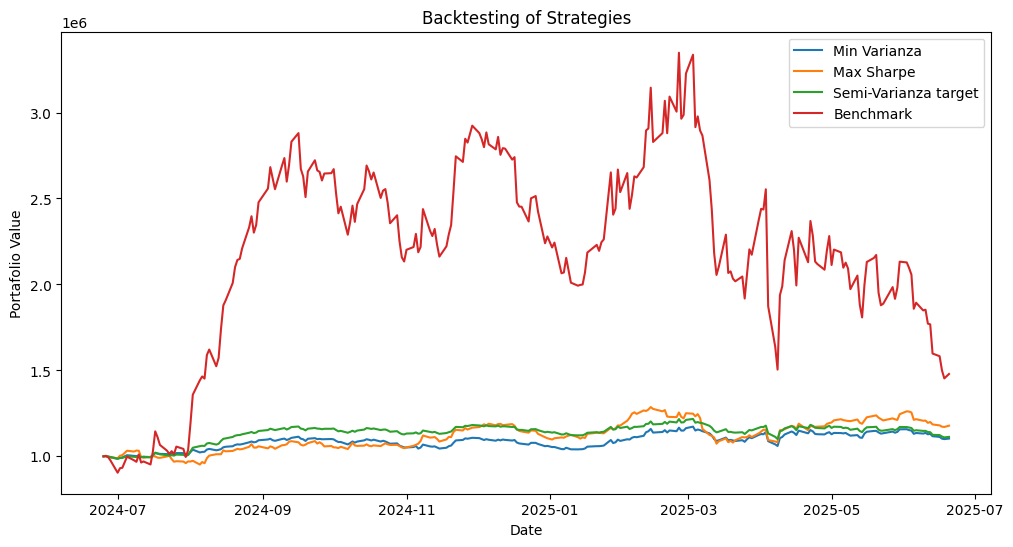

In [342]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

In [343]:
metricas = metrics(history, 0.045)
metricas

,Min Varianza,Max Sharpe,Semi-Varianza target,Benchmark
Rendimientos,11.106550,18.893743,11.797805,82.584635
Volatilidad,231.406673,329.261451,209.851493,1468.960453
Sharpe Ratio,0.047801,0.057246,0.056005,0.056189
downside,0.094812,0.148107,0.084384,0.590685
upside,0.099548,0.138351,0.092384,0.646688
Omega,1.049947,0.934132,1.094810,1.094810
beta,0.148877,0.153238,0.142857,1.000000
Alpha Jensen,-1.226720,6.200527,-0.038571,0.000000
Treynor,74.299822,123.002988,82.269635,82.539635
Sortino,116.668018,127.264710,139.278367,139.735463


In [344]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_min_var(rets_bt)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt

,w,Cash,No. Acciones
Ticker,,,
CLX,0.045780,45779.663838,379.0
COST,0.184887,184887.396342,188.0
K,0.327643,327642.714790,4164.0
KHC,0.068202,68201.784829,2643.0
KO,0.291149,291148.559045,4229.0
PG,0.048376,48375.593931,304.0
WMT,0.033964,33964.287225,353.0


---

#### Con diferentes activos

In [345]:
tickers = ['LLY', 'ISRG', 'ABBV', 'JNJ', 'MRK']

In [346]:
opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['KXI'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [347]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
rets_bt = bt_prices.pct_change().dropna()
corr = rets.corr()


---

#### Mínima Varianza 

In [348]:
w_minvar = opt_min_var(rets)

#### Máximo de Sharpe

In [349]:
w_maxsharpe = opt_max_sharpe(rets, 0.045)

#### Semi Varianza Target

In [350]:
w_semivar = objetivo(rets, rets_b, corr)

#### Backtesting

##### Capital

In [351]:
capital = 1000000

In [352]:
w_dict= {
    'Min Var' : w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi Var': w_semivar,
    'Benchmark': 1
}

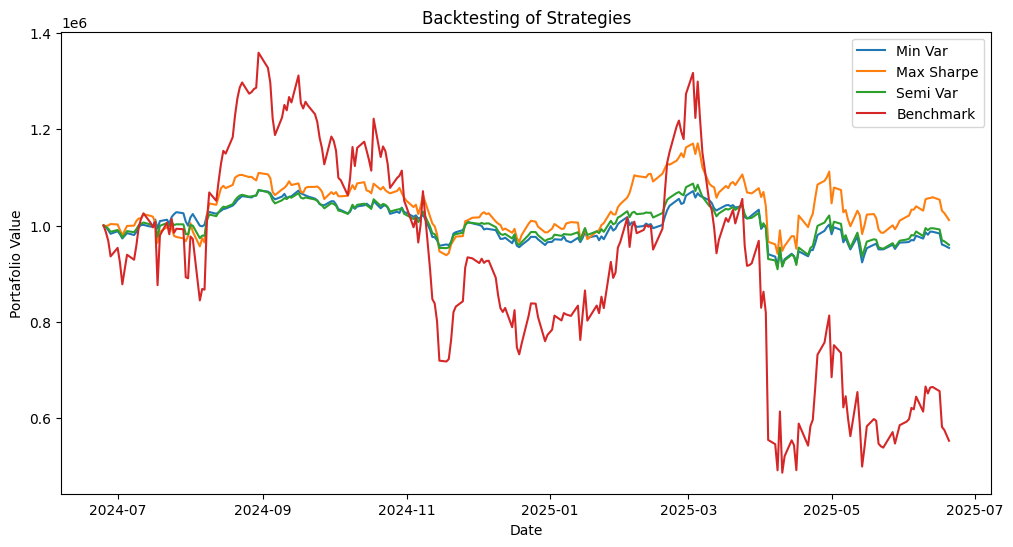

In [353]:
history = backtesting(bt_prices,benchmark, w_dict, capital )

In [354]:
metrics(history, rf= 0.045)


,Min Var,Max Sharpe,Semi Var,Benchmark
Rendimientos,-3.311074,4.585947,-2.298111,-11.490555
Volatilidad,279.469176,416.587734,309.152395,1545.761976
Sharpe Ratio,-0.012009,0.010900,-0.007579,-0.007463
downside,0.141611,0.200320,0.151833,0.759166
upside,0.099308,0.173325,0.125341,0.626703
Omega,0.701272,0.865244,0.825516,0.825516
beta,0.171365,0.248053,0.200000,1.000000
Alpha Jensen,-1.379286,7.402381,-0.036000,0.000000
Treynor,-19.584386,18.306323,-11.715555,-11.535555
Sortino,-23.699285,22.668478,-15.432140,-15.195038


#### Portafolio Real 

In [355]:
re_opt = pd.DataFrame(index=rets.columns)
re_opt['w'] = opt_max_sharpe(rets_bt, 0.045)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt['w'].sum()
re_opt

,w,Cash,No. Acciones
Ticker,,,
ABBV,4.111758e-01,4.111758e+05,2218.0
ISRG,5.888242e-01,5.888242e+05,1156.0
JNJ,8.112496e-16,8.112496e-10,0.0
LLY,0.000000e+00,0.000000e+00,0.0
MRK,0.000000e+00,0.000000e+00,0.0


---